In [657]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [658]:
data = load_iris()

In [659]:
X = data.data
y = data.target
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)
Y_train_encoded = OneHotEncoder().fit_transform(Y_train.reshape(-1, 1)).toarray()
Y_test_encoded = OneHotEncoder().fit_transform(Y_test.reshape(-1, 1)).toarray()

X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
Y_train_encoded = tf.convert_to_tensor(Y_train_encoded)
Y_test_encoded = tf.convert_to_tensor(Y_test_encoded)

n0, m_total = X.shape
print(X_train.shape)
print(X_test.shape)
print(Y_train_encoded.shape)
print(Y_test_encoded.shape)

(120, 4)
(30, 4)
(120, 3)
(30, 3)


## My naive network

In [660]:
def loss(Y, AL, eps=1.e-7):
    M = AL.shape[0]
    L = tf.reduce_sum(-Y * tf.math.log(tf.clip_by_value(AL, eps, 1 - eps))) / M
    return L

def get_dAL(Y, AL, eps=1.e-7):
    M = AL.shape[0]
    return - Y / tf.clip_by_value(AL, eps, 1 - eps) / M

def get_dA(dZ_post, W_post):
    return dZ_post @ tf.transpose(W_post)

def get_dZL(Y, AL):
    M = AL.shape[0]
    return (AL * tf.reduce_sum(Y, axis=1, keepdims=True) - Y) / M

def get_dZ(dA, Z, g_der):
    return dA * g_der(Z)

def get_dweights(A_prev, dZ):
    dW = tf.transpose(A_prev) @ dZ
    db = tf.reduce_sum(dZ, axis=0)
    return dW, db

def relu_der(Z):
    return tf.cast(Z > 0, dtype=tf.float64)

def softmax_der(Z):
    softmax_Z = softmax(Z)
    return softmax_Z * (1 - softmax_Z)

def softmax(Z):
    denominator = tf.reduce_sum(tf.exp(Z), axis=1, keepdims=True)
    return tf.exp(Z) / denominator

In [661]:
def init_uniform(shape):
    tf.random.set_seed(0)
    weights = {}
    for i in range(1, len(shape)):
        weights[f'W{i}'] = tf.random.uniform((shape[i - 1], shape[i]), dtype=tf.float64)
        weights[f'b{i}'] = tf.random.uniform((shape[i], ), dtype=tf.float64)
    return weights

def update(weights, dweights, learning_rate):
    for key in weights.keys():
        weights[key] -= learning_rate * dweights[f'd{key}']

def forward_prop(X_train, weights):
    W1 = weights['W1']
    b1 = weights['b1']
    W2 = weights['W2']
    b2 = weights['b2']

    Zs = {}
    As = {}
    Z1 = X_train @ W1 + b1
    A1 = tf.nn.relu(Z1)
    Z2 = A1 @ W2 + b2
    A2 = tf.nn.softmax(Z2)
    Zs["Z1"] = Z1
    As["A1"] = A1
    Zs["Z2"] = Z2
    As["A2"] = A2
    return Zs, As

def backward_prop(X_train, Y_train, weights, Zs, As):
    dweights = {}

    dA2 = get_dAL(Y_train, As["A2"])
    dZ2 = get_dZL(Y_train, As["A2"])
    dW2, db2 = get_dweights(As["A1"], dZ2)

    dA1 = get_dA(dZ2, weights["W2"])
    dZ1 = get_dZ(dA1, Zs["Z1"], relu_der)
    dW1, db1 = get_dweights(X_train, dZ1)
    dweights["dW1"] = dW1
    dweights["db1"] = db1
    dweights["dW2"] = dW2
    dweights["db2"] = db2
    return dweights

def train(X_train, Y_train, epochs=100, learning_rate=0.001, n1=10, verbose=True):
    n0 = X_train.shape[1]
    n2 = Y_train.shape[1]
    weights = init_uniform((n0, n1, n2))
    Zs, As = forward_prop(X_train, weights)
    history = {'loss': [], 'accuracy': []}
    for i in range(epochs):
        dweights = backward_prop(X_train, Y_train, weights, Zs, As)
        update(weights, dweights, learning_rate)
        Zs, As = forward_prop(X_train, weights)

        l = float(loss(Y_train, As["A2"]))
        acc = accuracy_score(tf.argmax(Y_train, axis=1), tf.argmax(As['A2'], axis=1))
        history['loss'].append(l)
        history['accuracy'].append(acc)
        if verbose and i % (epochs // 10) == 0:
            print('epoch', i + 1, 'loss:',l, 'acc:', acc)

    return history, weights, Zs, As

def predict(X, weights):
    A2 = forward_prop(X, weights)[1]["A2"]
    return tf.argmax(A2, axis=1)

In [662]:
history, weights, Zs, As = train(X_train, Y_train_encoded, epochs=150, learning_rate=0.003)

epoch 1 loss: 9.648960995973235 acc: 0.30833333333333335
epoch 16 loss: 1.0212939253229603 acc: 0.36666666666666664
epoch 31 loss: 0.9950905058417073 acc: 0.36666666666666664
epoch 46 loss: 0.9700010244038909 acc: 0.39166666666666666
epoch 61 loss: 0.9459320632294451 acc: 0.5583333333333333
epoch 76 loss: 0.922826578184769 acc: 0.6666666666666666
epoch 91 loss: 0.9006400284682189 acc: 0.6833333333333333
epoch 106 loss: 0.8793373713275563 acc: 0.6833333333333333
epoch 121 loss: 0.8588904263487217 acc: 0.6916666666666667
epoch 136 loss: 0.8392756237621076 acc: 0.6916666666666667


In [663]:
@tf.function
def get_gradient():
    W1 = weights['W1']
    b1 = weights['b1']
    W2 = weights['W2']
    b2 = weights['b2']
    Z1 = X_train @ W1 + b1
    A1 = tf.nn.relu(Z1)
    Z2 = A1 @ W2 + b2
    A2 = tf.nn.softmax(Z2)
    L = loss(Y_train_encoded, A2)
    return tf.gradients(L, [W1, b1, W2, b2, Z1, A1, Z2, A2])

dW1, db1, dW2, db2, dZ1, dA1, dZ2, dA2 = get_gradient()

tol = 1.e-10
tf.debugging.assert_near(dA2, get_dAL(Y_train_encoded, As['A2']), rtol=tol, atol=tol)
tf.debugging.assert_near(dZ2, get_dZL(Y_train_encoded, As['A2']), rtol=tol, atol=tol)
tf.debugging.assert_near(dW2, get_dweights(As['A1'], dZ2)[0], rtol=tol, atol=tol)
tf.debugging.assert_near(db2, get_dweights(As['A1'], dZ2)[1], rtol=tol, atol=tol)
tf.debugging.assert_near(dA1, get_dA(dZ2, weights['W2']), rtol=tol, atol=tol)
tf.debugging.assert_near(dZ1, get_dZ(dA1, Zs['Z1'], relu_der), rtol=tol, atol=tol)
tf.debugging.assert_near(dW1, get_dweights(X_train, dZ1)[0], rtol=tol, atol=tol)
tf.debugging.assert_near(db1, get_dweights(X_train, dZ1)[1], rtol=tol, atol=tol)

In [664]:
predict(X_train, weights)

<tf.Tensor: shape=(120,), dtype=int64, numpy=
array([2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0,
       2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 0], dtype=int64)>

## Keras

In [665]:
tf.random.set_seed(2)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(tf.keras.layers.Dense(Y_train_encoded.shape[1], activation='softmax'))
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 10)                50        
                                                                 
 dense_43 (Dense)            (None, 3)                 33        
                                                                 
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________


In [666]:
loss(Y_train_encoded, tf.cast(model(X_train), dtype=tf.float64))

<tf.Tensor: shape=(), dtype=float64, numpy=3.253091535668539>

In [667]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss='categorical_crossentropy')
history = model.fit(X_train, Y_train_encoded, epochs=150, validation_data=(X_test, Y_test_encoded))

Epoch 1/150
4/4 [==============================] - 0s 39ms/step - loss: 3.0993 - val_loss: 2.8421
Epoch 2/150
4/4 [==============================] - 0s 8ms/step - loss: 2.7226 - val_loss: 2.6166
Epoch 3/150
4/4 [==============================] - 0s 9ms/step - loss: 2.4429 - val_loss: 2.4884
Epoch 4/150
4/4 [==============================] - 0s 10ms/step - loss: 2.2682 - val_loss: 2.4142
Epoch 5/150
4/4 [==============================] - 0s 9ms/step - loss: 2.1711 - val_loss: 2.3348
Epoch 6/150
4/4 [==============================] - 0s 9ms/step - loss: 2.0633 - val_loss: 2.2164
Epoch 7/150
4/4 [==============================] - 0s 9ms/step - loss: 1.9570 - val_loss: 2.0641
Epoch 8/150
4/4 [==============================] - 0s 9ms/step - loss: 1.8215 - val_loss: 1.8964
Epoch 9/150
4/4 [==============================] - 0s 9ms/step - loss: 1.7001 - val_loss: 1.7321
Epoch 10/150
4/4 [==============================] - 0s 8ms/step - loss: 1.5893 - val_loss: 1.5781
Epoch 11/150
4/4 [=========

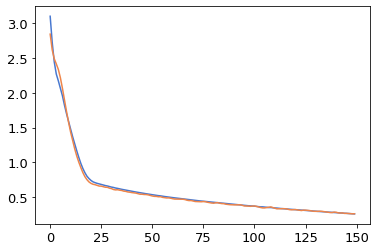

In [668]:
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 13})
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(len(history.history['loss'])), history.history['loss'])
ax.plot(range(len(history.history['val_loss'])), history.history['val_loss'])

In [669]:
y_pred = np.argmax(model.predict(X_train), axis=1)
print('train accuracy:', accuracy_score(Y_train, y_pred))
y_pred = np.argmax(model.predict(X_test), axis=1)
print('test accuracy:', accuracy_score(Y_test, y_pred))

4/4 [==============================] - 0s 1ms/step
train accuracy: 0.9666666666666667
1/1 [==============================] - 0s 17ms/step
test accuracy: 0.9666666666666667


For comparison, use logistic regression provided by sklearn to predict result.

In [670]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
X = data.data
y = data.target
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)
clf.fit(X_train, Y_train.flatten())

LogisticRegression()

In [671]:
y_pred = clf.predict(X_train)
print('train accuracy:', accuracy_score(Y_train, y_pred))
y_pred = clf.predict(X_test)
print('test accuracy:', accuracy_score(Y_test, y_pred))

train accuracy: 0.9833333333333333
test accuracy: 0.9666666666666667
